In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras import models
from keras import layers
from keras import optimizers
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense
from keras.layers import Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

Using TensorFlow backend.


In [2]:
data = pd.read_csv("admData.csv")
data.head()

,InquiryDate,DailyAdmission
0,8/22/2017,41
1,8/23/2017,47
2,8/24/2017,56
3,8/25/2017,63
4,8/26/2017,70


In [3]:
from datetime import datetime
con= data['InquiryDate']
data['InquiryDate'] = pd.to_datetime(data['InquiryDate'])
data.set_index('InquiryDate', inplace = True)

In [4]:
data = data['2017-08-22': '2018-08-16']

In [5]:
np.random.seed(9001)
train_portion = round(data.shape[0]*.6)
val_portion = round(data.shape[0]*.2)

train_data = data[0:train_portion]
val_data = data[train_portion: val_portion+train_portion]

test_data =data[train_portion+val_portion:]

In [6]:
tr_data = train_data['DailyAdmission']
ts_data = test_data['DailyAdmission']

/opt/homebrew/Cellar/python36/3.6.2+_254.20170915/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


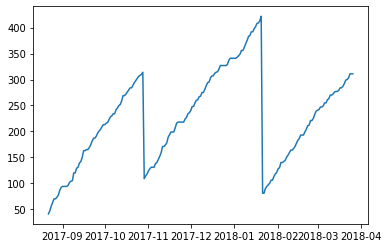

In [7]:
plt.plot(tr_data)

In [8]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries): 
    #determining rolling statistics
    rolmean = timeseries.rolling(7).mean()
    rolstd = timeseries.rolling(7).std()
    
    
    #plot rolling statistics: 
    plt.plot(timeseries, color = 'blue', label = 'Original')
    plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    plt.plot(rolstd, color = 'black', label ='Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling mean & Standard Deviation')
    plt.show()
    
    #perform dickey-fuller test:
    print('results of dickey-fuller test: ')
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistics', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s): ' %key]  = value
    print(dfoutput)
    

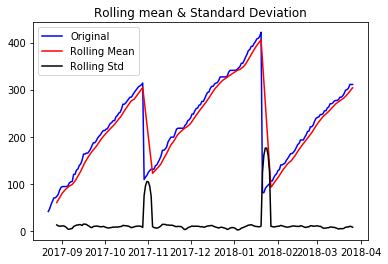

results of dickey-fuller test: 
Test Statistics                 -2.684784
p-value                          0.076709
#Lags Used                       0.000000
Number of Observations Used    214.000000
Critical Value (1%):            -3.461282
Critical Value (5%):            -2.875143
Critical Value (10%):           -2.574020
dtype: float64


In [9]:
test_stationarity(tr_data)

In [10]:
tr_data

InquiryDate
2017-08-22     41
2017-08-23     47
2017-08-24     56
2017-08-25     63
2017-08-26     70
2017-08-27     70
2017-08-28     73
2017-08-29     77
2017-08-30     86
2017-08-31     92
2017-09-01     94
2017-09-02     94
2017-09-03     94
2017-09-04     94
2017-09-05     96
2017-09-06    102
2017-09-07    104
2017-09-08    105
2017-09-09    120
2017-09-10    120
2017-09-11    129
2017-09-12    131
2017-09-13    139
2017-09-14    142
2017-09-15    150
2017-09-16    163
2017-09-17    163
2017-09-18    165
2017-09-19    165
2017-09-20    169
             ... 
2018-02-25    221
2018-02-26    225
2018-02-27    233
2018-02-28    239
2018-03-01    241
2018-03-02    242
2018-03-03    247
2018-03-04    247
2018-03-05    249
2018-03-06    255
2018-03-07    255
2018-03-08    261
2018-03-09    263
2018-03-10    270
2018-03-11    270
2018-03-12    272
2018-03-13    276
2018-03-14    277
2018-03-15    277
2018-03-16    279
2018-03-17    284
2018-03-18    284
2018-03-19    287
2018-03-20    29

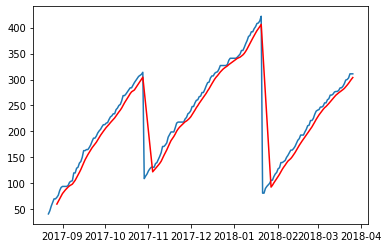

In [11]:
moving_avg = tr_data.rolling(7).mean()
plt.plot(tr_data)
plt.plot(moving_avg, color = 'red')

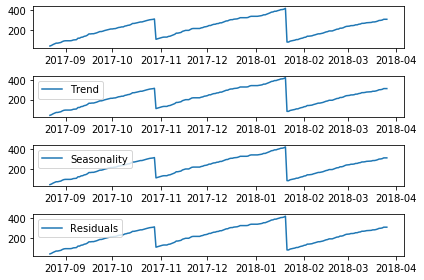

In [12]:

decomposition = seasonal_decompose(tr_data, freq=13)

decomp = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(tr_data, label = 'Original')
#plt.legend(log = 'best')
plt.subplot(412)
plt.plot(tr_data, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(tr_data, label = 'Seasonality')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(tr_data, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

/Users/tnorlund/Library/Python/3.6/lib/python/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Partial Autocorrelation Function')

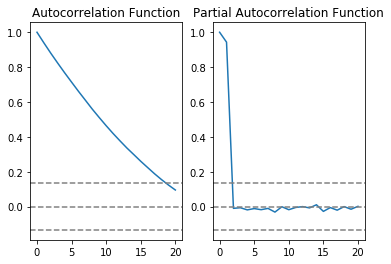

In [13]:
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(tr_data, nlags = 20)
lag_pacf = pacf(tr_data, nlags = 20, method = 'ols')

#Plot ACF

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y = 0, linestyle = '--', color = 'gray')
plt.axhline(y = -1.96/np.sqrt(len(tr_data)), linestyle = '--', color = 'grey')
plt.axhline(y=1.96/np.sqrt(len(tr_data)), linestyle = '--', color = 'gray')
plt.title('Autocorrelation Function')

#plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y = 0, linestyle = '--', color = 'gray')
plt.axhline(y = -1.96/np.sqrt(len(tr_data)), linestyle = '--', color = 'gray')
plt.axhline(y = 1.96/np.sqrt(len(tr_data)), linestyle = '--', color = 'gray')
plt.title('Partial Autocorrelation Function')
# plt.title_layout()

AR model

/Users/tnorlund/Library/Python/3.6/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/tnorlund/Library/Python/3.6/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS: 269.7004')

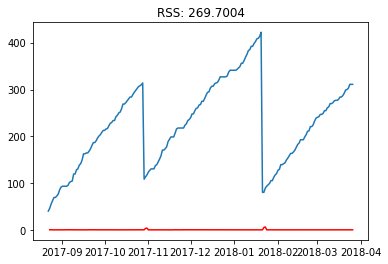

In [14]:
model = ARIMA(tr_data, order = (2,1,0))
results_AR = model.fit(disp = 7)
plt.plot(tr_data)
plt.plot(results_AR.fittedvalues, color = 'red')
plt.title('RSS: %.4f' % sum((results_AR.fittedvalues)))

MA Model

/Users/tnorlund/Library/Python/3.6/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/tnorlund/Library/Python/3.6/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS: 269.6962')

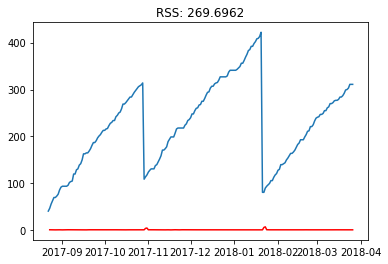

In [15]:
model = ARIMA(tr_data, order = (0,1,2))
results_MA = model.fit(disp = 7)
plt.plot(tr_data)
plt.plot(results_MA.fittedvalues, color = 'red')
plt.title('RSS: %.4f' % sum((results_MA.fittedvalues)))

ARIMA Model

In [16]:
model = ARIMA(tr_data, order = (2,1,2))
# results_ARIMA = model.fit(disp = 1)
# plt.plot(tr_data)
# plt.plot(results_ARIMA.fittedvalues, color = 'red')
# plt.title('RSS: %.4f' % sum((results_ARIMA.fittedvalues)**2))

/Users/tnorlund/Library/Python/3.6/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/tnorlund/Library/Python/3.6/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


The MA model has a better RSS but still not good

In [17]:
#RMSE

#predictions_MA = np.exp(predictions_MA_log)
